In [1]:
#import dataset from xlsx
import pandas as pd

def import_dataset(file_path):
    df = pd.read_excel(file_path)
    return df
    

In [3]:
# importing dataset from rootdir
df = import_dataset('./../Cleaned_Data.xlsx')

In [4]:
df.head()

,ID,Age,Horodateur,Niveau_scolaire,Genre_,Situation_Matrimoniale_(SM),Profession_,Arrondissement_de_résidence_,Quartier_de_Résidence_,Nationalité_,Religion_,A-t-il_(elle)_déjà_donné_le_sang_,ÉLIGIBILITÉ_AU_DON.
0,DONOR_1842,24,46:44.9,3,1,0,Etudiant (e),Douala 3,Yassa,Camerounaise,Chretien (Catholique),0,1
1,DONOR_1843,23,44:19.0,3,1,0,Sans Emplois,Pas Précisé,Pas Précisé,Camerounaise,Chretien (Catholique),1,0
2,DONOR_1844,41,46:54.3,0,1,2,Tailleur,Douala 1,NEW BELL,Camerounaise,Pas Précisé,0,0
3,DONOR_1845,24,29:29.7,3,1,0,Etudiant,Douala 5,Ange raphael,Camerounaise,Musulman,0,1
4,DONOR_1846,30,47:47.4,2,1,0,Militaire,Douala (Non précisé ),Beedi,Camerounaise,Adventiste,1,1


In [5]:
# Drop unnecessary columns
df.drop(columns=["ID", "Horodateur"], inplace=True)

# Convert categorical variables to numerical (Encoding)
categorical_columns = ["Niveau_scolaire", "Genre_", "Situation_Matrimoniale_(SM)", 
                       "Profession_", "Arrondissement_de_résidence_", "Quartier_de_Résidence_", 
                       "Nationalité_", "Religion_"]

df = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

# Display updated dataframe
print(df.head())

   Age  A-t-il_(elle)_déjà_donné_le_sang_  ÉLIGIBILITÉ_AU_DON.  \
0   24                                  0                    1   
1   23                                  1                    0   
2   41                                  0                    0   
3   24                                  0                    1   
4   30                                  1                    1   

   Niveau_scolaire_0  Niveau_scolaire_1  Niveau_scolaire_2  Niveau_scolaire_3  \
0              False              False              False               True   
1              False              False              False               True   
2               True              False              False              False   
3              False              False              False               True   
4              False              False               True              False   

   Genre__1  Situation_Matrimoniale_(SM)_1  Situation_Matrimoniale_(SM)_2  \
0      True                          Fa

In [6]:
from sklearn.model_selection import train_test_split

# Define features (X) and target (y)
X = df.drop(columns=["ÉLIGIBILITÉ_AU_DON."])
y = df["ÉLIGIBILITÉ_AU_DON."]

# Split into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training set size: {X_train.shape}, Testing set size: {X_test.shape}")

Training set size: (1476, 1185), Testing set size: (370, 1185)


In [7]:
from sklearn.tree import DecisionTreeClassifier

# Initialize the model
model = DecisionTreeClassifier(criterion="gini", max_depth=5, random_state=42)

# Train the model
model.fit(X_train, y_train)

print("Model training completed.")

Model training completed.


In [8]:
from sklearn.metrics import accuracy_score, classification_report

# Predictions
y_pred = model.predict(X_test)

# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Classification report
print(classification_report(y_test, y_pred))

Accuracy: 0.86
              precision    recall  f1-score   support

           0       1.00      0.06      0.11        18
           1       0.86      1.00      0.92       314
           2       0.67      0.11      0.18        38

    accuracy                           0.86       370
   macro avg       0.84      0.39      0.40       370
weighted avg       0.85      0.86      0.81       370



IndexError: list index out of range

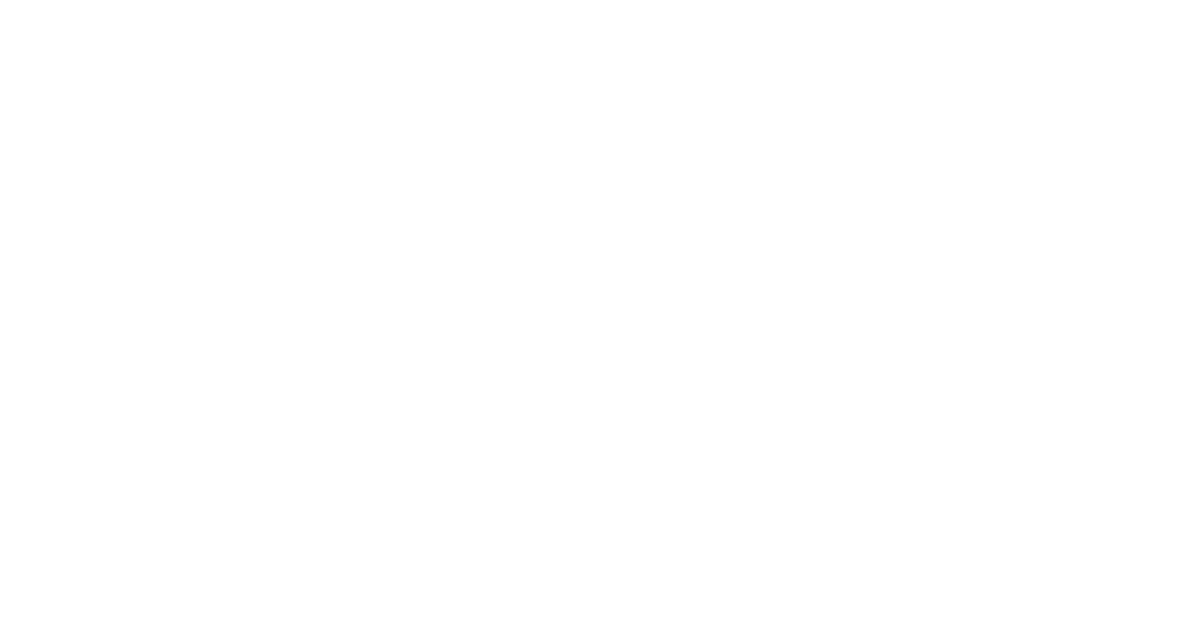

In [ ]:
# visualizing model
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree

plt.figure(figsize=(15, 8))
plot_tree(model, feature_names=X.columns, class_names=["Not Eligible", "Eligible"], filled=True)
plt.show()

In [12]:
# Example new donor data (replace values accordingly)
new_donor = pd.DataFrame([{
    "Age": 24,
    "Niveau_scolaire": 3,
    "Genre_": 1,
    "Situation_Matrimoniale_(SM)": 0,
    "Profession_": "Etudiant (e)",
    "Arrondissement_de_résidence_": "Douala 3",
    "Quartier_de_Résidence_": "Yassa",
    "Nationalité_": "Camerounaise",
    "Religion_": "Chretien (Catholique)",
    "A-t-il_(elle)_déjà_donné_le_sang_": 0
}])


# Convert categorical variables to numerical (Encoding)
new_donor = pd.get_dummies(new_donor, columns=categorical_columns, drop_first=True)
new_donor = new_donor.reindex(columns=X.columns, fill_value=0)

# Predict eligibility
eligibility = model.predict(new_donor)
print("Eligible for donation" if eligibility[0] == 1 else "Not eligible for donation")

Eligible for donation


In [13]:
# exporting our model
import joblib

# Save the trained model
joblib.dump(model, "blood_donation_model.pkl")

print("Model saved successfully!")

Model saved successfully!


In [14]:
# function to use our exported model to predict eligible donation
def predict_eligibility(new_data):
    """
    Loads the trained model and predicts eligibility for blood donation.
    
    Parameters:
        new_data (dict): A dictionary containing the input features.
    
    Returns:
        str: "Eligible for donation" or "Not eligible"
    """
    # Load the trained model
    model = joblib.load("blood_donation_model.pkl")

    # Convert input dictionary to DataFrame
    new_data_df = pd.DataFrame([new_data])

    # Apply one-hot encoding (ensure it matches training format)
    new_data_df = pd.get_dummies(new_data_df, columns=categorical_columns, drop_first=True)

    # Ensure same column structure as training data
    new_data_df = new_data_df.reindex(columns=X.columns, fill_value=0)

    # Make a prediction
    prediction = model.predict(new_data_df)

    # Return result
    return "Eligible for donation ✅" if prediction[0] == 1 else "Not eligible ❌"

In [16]:
# Example input (using data similar to our dataset)
new_donor = {
    "Age": 24,
    "Niveau_scolaire": 3,
    "Genre_": 1,
    "Situation_Matrimoniale_(SM)": 0,
    "Profession_": "Etudiant (e)",
    "Arrondissement_de_résidence_": "Douala 3",
    "Quartier_de_Résidence_": "Yassa",
    "Nationalité_": "Camerounaise",
    "Religion_": "Chretien (Catholique)",
    "A-t-il_(elle)_déjà_donné_le_sang_": 0
}

# Predict eligibility
result = predict_eligibility(new_donor)
print(result)

Eligible for donation ✅
